In [47]:
import requests
import json
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



In [ ]:
# Import line_profiler if installed
try:
    from line_profiler import LineProfiler
    profile = LineProfiler()
except ImportError:
    def profile(f):
        return f

In [48]:
should_download_data = False
reset_event_data = False

# Get Games
Fetch games and their id's for multiple months to collect data

In [49]:
# Set common variables
api_key = os.environ['SPORTRADAR_API_KEY']
access_level = 'trial'
version = 'v8'
language_code = 'en'
season_year = '2022'

In [50]:
if should_download_data:
    season_schedule = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{season_year}/REG/schedule.json?api_key={api_key}"
    response = requests.get(season_schedule)
    if response.status_code == 200:
        try:
            schedule_data = response.json()
        except ValueError as e:
            print("Error decoding JSON:", e)
    else:
        print("Failed to retrieve data: ", response.status_code)
    schedule_data = response.json()
    print(json.dumps(schedule_data, indent=4, sort_keys=True))

In [51]:
if should_download_data: 
    with (open("data/season_schedule.json", "w")) as f:
        json.dump(schedule_data, f, indent=4)

In [53]:
if should_download_data:

    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm

    def get_play_by_play(game_id):
        url = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{game_id}/pbp.json?api_key={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            try:
                return response.json()
            except ValueError as e:
                print("Error decoding JSON:", e)
        else:
            print("Failed to retrieve data: ", response.status_code)
        return None

    game_ids = [game['id'] for game in schedule_data['games']]

    play_by_play_data = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_game_id = {executor.submit(get_play_by_play, game_id): game_id for game_id in game_ids}
        for future in tqdm(as_completed(future_to_game_id), total=len(game_ids)):
            data = future.result()
            if data is not None:
                play_by_play_data.append(data)

    with open("data/play_by_play_data.json", "w") as f:
        json.dump(play_by_play_data, f, indent=4)

# Preprocessing Function Declarations

In [282]:
def process_game_level_data(df, target):
    # List of columns to drop initially
    columns_to_drop = ["lead_changes", "times_tied", "track_on_court", "deleted_events", 'coverage', 'scheduled', "status", "attendance", "clock", "duration", "reference", "entry_mode", "sr_id", "clock_decimal", "time_zones", "quarter"]
    # List of team features to drop
    team_features_to_drop = ["name", "alias", "market", "sr_id", "bonus", "remaining_timeouts", "reference", "points"]

    # Process home and away data
    for team in ['home', 'away']:
        team_data = pd.json_normalize(df[team]).drop(team_features_to_drop, axis=1, inplace=False)
        team_data.columns = [f'{team}_{col}' for col in team_data.columns]
        df = df.join(team_data)

    # Create features for home win percentage and away win percentage based on the team's record
    for team in ['home', 'away']:
        df[f'{team}_win_pct'] = df[f"{team}_record.wins"] / (df[f"{team}_record.wins"] + df[f"{team}_record.losses"])
        columns_to_drop.extend([f"{team}_record.wins", f"{team}_record.losses"])

    # Drop the home, away and record columns from the original dataframe
    columns_to_drop.extend(["home", "away"])
    df["target"] = target

    df.drop(columns_to_drop, axis=1, inplace=True)

    return df

In [287]:
import pandas as pd

def extract_periods(df):
    # Create an empty DataFrame to store the extracted data
    extracted_data = pd.DataFrame()

    features_to_keep = ['game_id','type', 'id', 'number', 'sequence', 'times_tied',
       'lead_changes', "events", "home_id", "away_id" , "home_win_pct", "away_win_pct", "target"]

    for i in range(len(df)):
        # Iterate through each game entry
        game_id = df['id'].iloc[i]
        periods = df['periods'].iloc[i]
        target = df['target'].iloc[i]
        home_win_pct = df['home_win_pct'].iloc[i]
        away_win_pct = df['away_win_pct'].iloc[i]

        for period in periods:
            # For each period, flatten the period data and the nested 'scoring' data
            period_data = pd.json_normalize(period)
            scoring_data = pd.json_normalize(period['scoring'])

            # Combine period data with scoring data
            combined_data = pd.concat([period_data, scoring_data], axis=1)

            # Add game-level information (e.g., game ID)
            combined_data['game_id'] = game_id
            combined_data['target'] = target
            combined_data['home_win_pct'] = home_win_pct
            combined_data['away_win_pct'] = away_win_pct
            combined_data["home_id"] = df["home_id"].iloc[i]
            combined_data["away_id"] = df["away_id"].iloc[i]

            # If times_tied doesn't exist, fill it with 0
            if 'times_tied' not in combined_data.columns:
                combined_data['times_tied'] = 0

            # Append to the extracted_data DataFrame
            extracted_data = pd.concat([extracted_data, combined_data], ignore_index=True)

    # Keep only the columns we want
    extracted_data = extracted_data[features_to_keep]

    return extracted_data

In [293]:
from enum import Enum
import numpy as np
from tqdm import tqdm
from collections import deque

class Team(Enum):
    HOME = 1
    AWAY = 0
    TIED = -1


def convert_to_timedelta(time_str):
    if '.' in time_str:
        # Format '00:ss.ms'
        minutes = '00'
        seconds, milliseconds = time_str.split('.')
        seconds = seconds.zfill(2)  # Ensure two digits in seconds
        time_formatted = f'{minutes}:{seconds}.{milliseconds}'
    else:
        # Format 'mm:ss'
        minutes, seconds = time_str.split(':')
        minutes = minutes.zfill(2)  # Ensure two digits in minutes
        time_formatted = f'00:{minutes}:{seconds}'

    return pd.to_timedelta(time_formatted)

def calculate_game_time_remaining(quarter_number, clock_decimal):
    try:
        total_time_per_quarter = pd.to_timedelta('00:12:00')
        game_time_remaining = np.where(quarter_number <= 4,
                                       (4 - quarter_number) * total_time_per_quarter + clock_decimal,
                                       clock_decimal)

        # Convert game_time_remaining to seconds
        game_time_remaining_seconds = game_time_remaining / np.timedelta64(1, 's')

        return game_time_remaining_seconds
    except OverflowError as e:
        print(f"Error processing sequence {quarter_number}, clock_decimal {clock_decimal}: {e}")
        return pd.NaT
    
def calculate_scoring_run(recent_scoring, max_window_size=25):
    current_window_size = min(len(recent_scoring), max_window_size)
    if current_window_size > 0:  # Ensure at least one event is in the window
        recent_list = list(recent_scoring)  # Convert deque to list for slicing
        return max(recent_list[-current_window_size:]) - min(recent_list[-current_window_size:])
    return 0  # Default value if no events yet



def encode_leading_team(row, home_id, away_id):
    if pd.isna(row['current_leading_team_id']):
        return Team.TIED.value  # Tie
    elif row['current_leading_team_id'] == away_id:
        return Team.AWAY.value  # Away team leads
    elif row['current_leading_team_id'] == home_id:
        return Team.HOME.value
    else:
        raise Exception(f"Unexpected leading team ID: {row['current_leading_team_id']}, home ID: {home_id}, away ID: {away_id}")

In [300]:
import time

@profile
def extract_events(df): 
    start_time = time.time()
    extracted_data_frame = pd.DataFrame()
    print(df["home_win_pct"].iloc[0])

    CLOSE_GAME_THRESHOLD = 5
    CRITICAL_TIME_THRESHOLD = 300
    # RECENT_EVENTS_WINDOW = 25 # Number of events to keep in the recent scoring deque

    last_known_leading_team = None
    previous_score_difference = None
    lead_change_count = 0
    times_tied_count = 0
    # recent_scoring = deque(maxlen=RECENT_EVENTS_WINDOW)

    # Apply normalization and standardization
    # Initialize scalers
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    # Normalize and standardize
    features_to_normalize = ['game_time_remaining']
    features_to_standardize = ['home_points', 'away_points', 'current_score_difference', 'lead_changes', 'times_tied']

    win_pct_dict = {}

    all_events = []

    home_id = df['home_id'].iloc[0]
    away_id = df['away_id'].iloc[0]

    # Add tqdm() around the range to create a progress bar
    for i in tqdm(range(len(df))):

        game_id = df['game_id'].iloc[i]
        events = df['events'].iloc[i]
        quarter_number = df['sequence'].iloc[i]
        max_quarter_number = df["sequence"].max()       
        
        events = [event for event in events if event['event_type'] not in ['lineupchange', 'timeout', 'endtimeout', "teamtimeout", "flagrantone", "flagranttwo", "stoppage", "opentip", "delay", "jumpball", "review", "kickball", "jumpballviolation", "doublelane", "ejection"]]

        if game_id in win_pct_dict:
            home_win_pct, away_win_pct, target = win_pct_dict[game_id]
        else:
            home_win_pct = df['home_win_pct'].iloc[i]
            away_win_pct = df['away_win_pct'].iloc[i]
            target = df['target'].iloc[i]
            win_pct_dict[game_id] = (home_win_pct, away_win_pct, target)

        normalize_total_diff = 0
        for event in events:    
            event_entry = pd.json_normalize(event)
            event_entry['game_id'] = game_id
            event_entry["quarter_number"] = quarter_number
            is_end_of_game = (event_entry['event_type'] == 'endperiod') & (quarter_number == max_quarter_number)            
            event_entry['is_end_of_game'] = is_end_of_game
            event_entry.drop(['event_type'], axis=1, inplace=True)
            if 'possession.id' not in event_entry.columns:
                event_entry['possession.id'] = None


            # Time remaining in game feature
            event_entry['clock_decimal'] = event_entry['clock_decimal'].apply(convert_to_timedelta)
            event_entry['game_time_remaining'] = calculate_game_time_remaining(event_entry['quarter_number'], event_entry['clock_decimal'])
            event_entry["current_score_difference"] = event_entry["home_points"] - event_entry["away_points"];
            event_entry["current_leading_team_id"] = np.where(event_entry["current_score_difference"] > 0, home_id, np.where(event_entry["current_score_difference"] < 0, away_id, None))            
            current_score_difference = event_entry["current_score_difference"].iloc[0]

            # Determine the current leading team
            if current_score_difference > 0:
                current_leading_team = Team.HOME.value
            elif current_score_difference < 0:
                current_leading_team = Team.AWAY.value
            else:
                current_leading_team = Team.TIED.value

            # Update lead change count
            if last_known_leading_team is not None and last_known_leading_team != Team.TIED and current_leading_team != Team.TIED and current_leading_team != last_known_leading_team:
                lead_change_count += 1

            if current_leading_team != Team.TIED:
                last_known_leading_team = current_leading_team
            # Add lead change count and times tied count to the DataFrame
            event_entry['lead_changes'] = lead_change_count
            
            # Update times tied
            if previous_score_difference is not None and previous_score_difference != 0 and current_score_difference == 0:
                times_tied_count += 1
            previous_score_difference = current_score_difference
            event_entry['times_tied'] = times_tied_count

            
            # # Recent scoring
            # recent_scoring.append(current_score_difference)
            # event_entry['scoring_run'] = calculate_scoring_run(recent_scoring)
                        
            event_entry['is_close_game'] = event_entry['current_score_difference'].abs() <= CLOSE_GAME_THRESHOLD & (event_entry['game_time_remaining'] <= CRITICAL_TIME_THRESHOLD)
            
            try:
                event_entry['critical_possession'] = event_entry['is_close_game'] & (event_entry['game_time_remaining'] <= CRITICAL_TIME_THRESHOLD) & (event_entry['possession.id'] == event_entry['current_leading_team_id'])
            except KeyError: 
                event_entry['critical_possession'] = False

            # Pre-computed values
            event_entry['home_win_pct'] = home_win_pct
            event_entry['away_win_pct'] = away_win_pct
            event_entry["target"] = target
            
            try:
                event_entry['home_possession'] = (event_entry['possession.id'] == event_entry['on_court.home.id']).astype(int)
                event_entry['away_possession'] = (event_entry['possession.id'] == event_entry['on_court.away.id']).astype(int)
                event_entry['no_possession'] = event_entry['possession.id'].isna().astype(int)
            except KeyError:
                event_entry['home_possession'] = 0
                event_entry['away_possession'] = 0
                event_entry['no_possession'] = 1

            event_entry['encoded_leading_team'] = event_entry.apply( lambda row: encode_leading_team(row, home_id, away_id), axis=1)

            event_entry.drop(['clock_decimal'], axis=1, inplace=True)

            all_events.append(event_entry)

    
    concat_start_time = time.time()
    extracted_data_frame = pd.concat(all_events, ignore_index=True)
    concat_end_time = time.time()
    print(f"Time taken for concatenation: {concat_end_time - concat_start_time} seconds")

    normalization_start_time = time.time()

    extracted_data_frame[features_to_normalize] = minmax_scaler.fit_transform(extracted_data_frame[features_to_normalize])
    # Apply standardization
    extracted_data_frame[features_to_standardize] = standard_scaler.fit_transform(extracted_data_frame[features_to_standardize])
    normalization_end_time = time.time()
    normalize_total_diff += (normalization_end_time - normalization_start_time)
    print(f"Time taken for normalization: {normalization_end_time - normalization_start_time} seconds")

    features_to_keep = ['home_points', 'away_points', "quarter_number",
         "game_time_remaining", "current_score_difference", "is_close_game", "critical_possession",
         'lead_changes', 'times_tied', "home_win_pct", "away_win_pct", "target", "home_possession", "away_possession", "no_possession", "encoded_leading_team", "is_end_of_game" ]
    # features_to_add_later = ["on_court.home.players", "on_court.away.players", "statistics", "attempt"]
    extracted_data = extracted_data_frame[features_to_keep]
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time} seconds")
    print(f"Percentage of time the concatenation took compared to the total time: {(concat_end_time - concat_start_time) / (end_time - start_time)}")
    print(f"Percentage of time the normalize took compared to the total time: {normalize_total_diff / (end_time - start_time)}")
    return extracted_data



# Data Preprocessing

In [ ]:
def reprocess_data():
    with open("data/season_schedule.json", "r") as f:
        schedule_data = json.load(f)

    flat_data = schedule_data['games']

    game_level_df = pd.DataFrame(flat_data)
    target = game_level_df["home_points"] > game_level_df["away_points"]

    with open('data/play_by_play_data.json') as f:
        pbp_data = json.load(f)

    df = pd.DataFrame(pbp_data)
    df_processed = process_game_level_data(df, target)
    period_data = extract_periods(df_processed)
    event_data = extract_events(period_data)
    event_data.to_csv("data/event_data.csv", index=False)
    return event_data

modelling_event_data = None

if reset_event_data:
    modelling_event_data = reprocess_data()
    if 'LineProfiler' in globals():
        profile.print_stats()
elif modelling_event_data is not None:
    modelling_event_data = pd.read_csv("data/event_data.csv")
else:
    pass

## Split Data For Training

In [ ]:
from sklearn.model_selection import train_test_split

# Drop data that has NaN values
modelling_event_data.dropna(inplace=True)

X = modelling_event_data.drop(['target'], axis=1)  # Features
y = modelling_event_data['target']               # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Implement logistic regression with class balancing 
logreg_model = LogisticRegression(class_weight='balanced')
logreg_model.fit(X_train, y_train)


y_pred = logreg_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.02281D+04

At iterate   50    f=  2.39173D+05    |proj g|=  4.51381D+02

At iterate  100    f=  2.39160D+05    |proj g|=  2.30899D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    111      1     0     0   2.309D+01   2.392D+05
  F =   239160.43610471877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', verbose=1)

### Cross Validation

In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg_model, X, y, cv=5)
print("Cross-validated scores:", scores)


### Feature Importance Analysis

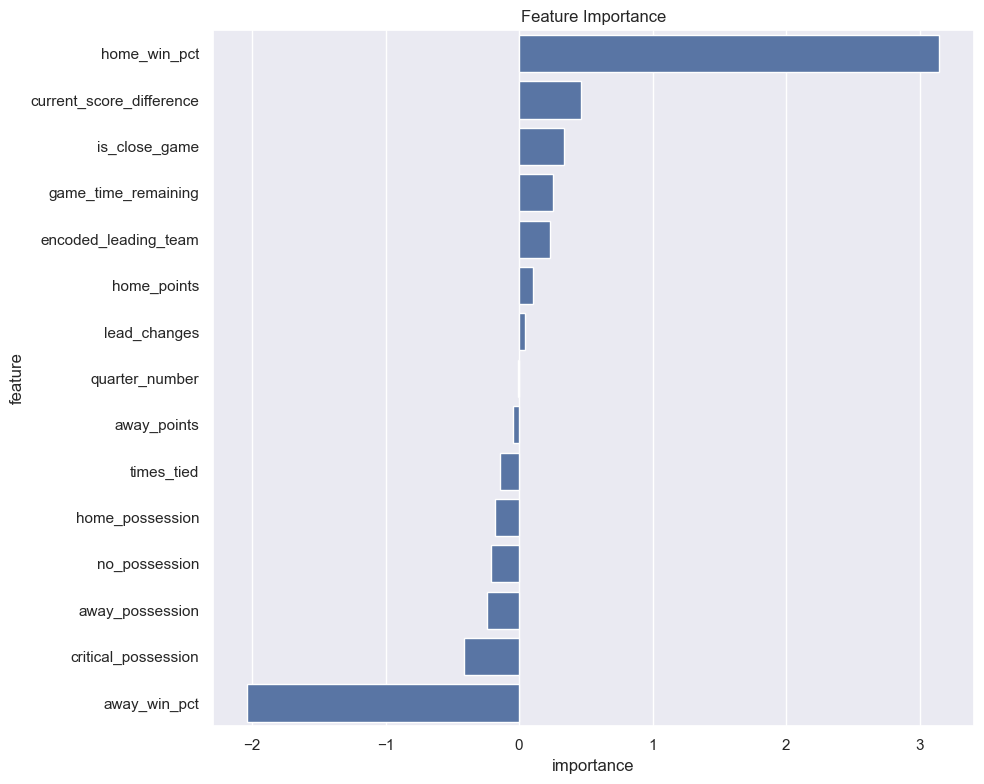

In [68]:
# Feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get feature importance from the model
feature_importance = pd.DataFrame(list(zip(X.columns, logreg_model.coef_[0])), columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Hyperparameter tuning

In [69]:
# # Implement GridSearchCV for hyperparameter tuning

# from sklearn.model_selection import GridSearchCV

# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# # Create grid search using 5-fold cross validation
# clf = GridSearchCV(logreg_model, hyperparameters, cv=5)

# # Fit grid search
# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])


### Single Game Win Probability Calculation

In [303]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class GamePredictor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.FIVE_MINUTES_NORMALIZED = 300 / 2880

    def predict_probabilities(self, df):
        _df_processed = process_game_level_data(df)    
        _period_data = extract_periods(_df_processed)
        _event_data = extract_events(_period_data)
        _event_data.dropna(inplace=True)
        return _event_data

    # Function to calculate time remaining including overtime
    @staticmethod
    def calc_time_remaining(row):
        if row['quarter_number'] <= 4:
            return row['game_time_remaining']
        elif row['quarter_number'] > 4:
            # Adjust for overtime: add the duration of each overtime period that has passed
            overtime_periods = row['quarter_number'] - 4
            return row['game_time_remaining'] - (GamePredictor.FIVE_MINUTES_NORMALIZED * overtime_periods)
        else:
            pass


    def extract_prob_data(self, path_to_single_game_data, model):
        # Open the file
        with open(path_to_single_game_data, "r") as f:
            single_game_data = json.load(f)

        single_game_df = pd.DataFrame(single_game_data)

        # Get the probabilities for each event
        single_game_event_data = self.predict_probabilities(single_game_df)

        # Apply this function to each row
        single_game_event_data['adjusted_time_remaining'] = single_game_event_data.apply(self.calc_time_remaining, axis=1)

        X = single_game_event_data.drop(['target', "adjusted_time_remaining", "is_game_over"], axis=1)  
        y = single_game_event_data['target'] 
        win_probabilities = model.predict_proba(X)

        win_probabilities = win_probabilities[:, 0]  # Adjust based on your class of interest
        return single_game_event_data, win_probabilities

    def plot_probabilities(self, single_game_event_data, win_probabilities): 
        plt.figure(figsize=(20, 8))
        # y axis is between 0 and 1, and shows it in increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.ylim(0, 1)

        max_quarter_number = single_game_event_data['quarter_number'].max() - 4

        plt.plot(single_game_event_data['adjusted_time_remaining'] * 2880, win_probabilities, color='blue', linewidth=4)

        plt.title('Win Probability For Away Team Uncalibrated')
        plt.xlabel('Time Remaining (s)')
        plt.ylabel('Win Probability')
        plt.gca().invert_xaxis()  # Reverse the x-axis
        plt.xlim(2900, GamePredictor.FIVE_MINUTES_NORMALIZED * max_quarter_number * 2880 * -1)
        plt.tight_layout()
        plt.show()


In [304]:
game_predictor = GamePredictor("data/event_data.csv")
single_game_event_data, win_probabilities = game_predictor.extract_prob_data("data/clehou181223.json" ,logreg_model)
game_predictor.plot_probabilities(single_game_event_data, win_probabilities)

NameError: name 'logreg_model' is not defined

### Calibrated model

In [267]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Calibrate the model
calibrated = CalibratedClassifierCV(lr, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

game_predictor = GamePredictor("data/event_data.csv")
single_game_event_data, win_probabilities = game_predictor.extract_prob_data("data/clehou181223.json", calibrated)
game_predictor.plot_probabilities(single_game_event_data, win_probabilities)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## AdaBoost

In [ ]:
# Implement AdaBoost

from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(n_estimators=500, random_state=42, learning_rate=0.1)
adaboost_model.fit(X_train, y_train)

y_pred = adaboost_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7096003608849885
              precision    recall  f1-score   support

       False       0.69      0.56      0.62     40824
        True       0.72      0.82      0.77     56714

    accuracy                           0.71     97538
   macro avg       0.70      0.69      0.69     97538
weighted avg       0.71      0.71      0.70     97538

Cross-validated scores: [0.58461318 0.61333019 0.58838606 0.59993643 0.41866164]


### Cross validation

In [ ]:
# scores = cross_val_score(model, X, y, cv=5)
# print("Cross-validated scores:", scores)

### Single Game Win Probability Calculation

In [ ]:
game_predictor = GamePredictor("data/event_data.csv")
single_game_event_data, win_probabilities = game_predictor.extract_prob_data("data/clehou181223.json", adaboost_model)
game_predictor.plot_probabilities(single_game_event_data, win_probabilities)

## XGBoost

In [ ]:
# Implement XGBoost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=500, random_state=42, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

### Single Game Win Probability Calculation

In [ ]:
game_predictor = GamePredictor("data/event_data.csv")
single_game_event_data, win_probabilities = game_predictor.extract_prob_data("data/clehou181223.json", xgb_model)
game_predictor.plot_probabilities(single_game_event_data, win_probabilities)